# LightwaveExplorer Data Analyzation & Visualization
This jupyter notebook gives a few data 

In [1]:
#Import Python modules
import LightwaveExplorer as lwe
import numpy as np
import pandas as pd
import seaborn as sns
#import ipywidgets as widgets
import matplotlib.pyplot as plt
import scipy as sp
import matplotlib
from scipy.signal import hilbert, chirp
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 14

### Loading Simulation Data and Structure Analyzation

In [27]:
# Insert the path to your simulation results here
SiO2_1mm_xpol = lwe.load("LWE-results/fused-silica-1mm-50nJ-30THz-10000nmbeamwaist-xpol.zip")
SiO2_2mm_xpol = lwe.load("LWE-results/fused-silica-2mm-50nJ-30THz-10000nmbeamwaist-xpol.zip")
SiO2_1mm_circpol = lwe.load("LWE-results/fused-silica-1mm-50nJ-30THz-10000nmbeamwaist-circpol.zip")
Vac_1mm_xpol = lwe.load("LWE-results/vacuum-1mm-50nJ-30THz-10000nmbeamwaist-xpol.zip")
#ZnSe_2mm = lwe.load("C:/Users/Admin/Seafile/LightWaveLab/LWE/Max-FROG/ZnSe-2000mm.zip")
#ZnSe_5mm = lwe.load("C:/Users/Admin/Seafile/LightWaveLab/LWE/Max-FROG/ZnSe-5000mm.zip")
#ZnSe_10mm = lwe.load("C:/Users/Admin/Seafile/LightWaveLab/LWE/Max-FROG/ZnSe-10000mm.zip")
#ZnSe_12mm = lwe.load("C:/Users/Admin/Seafile/LightWaveLab/LWE/Max-FROG/ZnSe-12000mm.zip")
#vac = lwe.load("C:/Users/Admin/Seafile/LightWaveLab/LWE/Max-FROG/vacuum.zip")

### Refractive Index

In [ ]:
#first we'll make a wavelength grid to work with
l = np.linspace(0.3,3,1024)

#next we'll need Sellmeier coefficients, these are for barium fluoride, H. H. Li., J. Phys. Chem. Ref. Data 9, 161-289 (1980)
a = lwe.getSellmeierFromRII("https://refractiveindex.info/database/data-nk/main/SiO2/Malitson.yml")
b = lwe.getSellmeierFromRII("https://refractiveindex.info/database/data-nk/main/BaF2/Malitson.yml")

#we can get the refractive index for the wavelengths we put in the grid by calling the sellmeier() function
#from the lightwaveExplorer module, with the equationType set to 0.
n = lwe.sellmeier(l, a, 0)
n2 = lwe.sellmeier(l, b, 0)

#let's make it so we can adjust the resonances of the oscillators and see how it affects the index

fig,ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(l,np.real(n),label="SiO2",color="blue")
ax.plot(l,np.real(n2), label = "BaF2", color = "red")
ax.set_xlabel("Wavelength (" + r'$\mu$' + "m)")
ax.set_ylabel("Refractive index n")
plt.title("Refractive index of different materials")
ax.legend()
plt.savefig("graphs/refractive-index-SiO2-BaF2")
plt.show()

### Create csv-File from LWE Results

In [ ]:
arr = np.array([ZnSe_2mm.timeVector * 1e15, vac.Ext_x[:,257]])
print(arr.shape)
#print()

np.savetxt('myarray.txt', arr)

### On-Axis Electric Field

In [ ]:
x = SiO2_1mm_xpol.timeVector * 1e15  # convert to fs
x2 = ZnSe_2mm.timeVector * 1e15
x3 = (ZnSe_2mm.timeVector * 1e15)[200:700]
y1 = SiO2_1mm_xpol.Ext_x[:,87]       # select on-axis column
y2 = SiO2_2mm_xpol.Ext_x[:,87]
y3 = SiO2_1mm_circpol.Ext_x[:,87]
y4 = Vac_1mm_xpol.Ext_x[:,87]
y5 = ZnSe_2mm.Ext_x[:,257]
y6 = ZnSe_5mm.Ext_x[:,257]
y7 = ZnSe_10mm.Ext_x[:,257]
y8 = ZnSe_12mm.Ext_x[:,257]
y9 = vac.Ext_x[:,257]
y10 = ZnSe_12mm.Ext_x[200:700,257]

b = np.where(y10<1e7,0,y10)
#print(b)

#print(x2.shape)
#print(ZnSe_12mm.Ext_x)
# FWHM's
print("FWHM-Vacuum: " + str(lwe.fwhm(x2, y9)))
print("FWHM-2mm: " + str(lwe.fwhm(x2, y5)))
print("FWHM-5mm: " + str(lwe.fwhm(x2, y6)))
print("FWHM-10mm: " + str(lwe.fwhm(x2, y7)))
print("FWHM-12mm: " + str(lwe.fwhm(x2, y8)))
#print(lwe.fwhm(x, y2))
#print(lwe.fwhm(x, y4))

plt.figure(figsize=(16, 8))
plt.plot(x2, y6, 'blue', label='Vacuum') #, FWHM=4.39fs
#plt.plot(x, y1, 'red', label='1mm SiO2') #, FWHM=7.56fs
#plt.plot(x, y2, 'blue', label='2mm SiO2') #, FWHM=19.81fs
plt.xlabel('Time [fs]')
plt.ylabel('Ex [GV/m]')
plt.title('On-Axis Electric Field in x-Polarization')
plt.legend()
plt.savefig('graphs/Vacuum-on-axis-electric-field-test')
plt.show()

In [13]:
phase = np.linspace(0, np.pi, num=5)
print(np.angle(1j)/np.pi)

0.5


### Pulse Envelope & FWHM

FWHM-Vacuum: 21.639237744010586


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


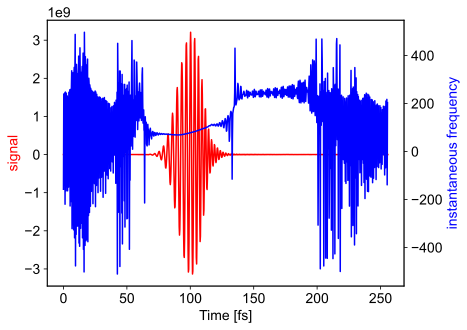

In [37]:
x = SiO2_1mm_xpol.timeVector * 1e15  # convert to fs
#x = Vac_1mm_xpol
y = SiO2_1mm_xpol.Ext_x[:,87]

fs = len(x)

# Compute the analytic signal, using the Hilbert transform. (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html)
# Zeroes out the negative half of the frequency spectrum, which yields a complex signal (only one exponential left)
analytic_signal = sp.signal.hilbert(y)
amplitude_envelope = np.abs(analytic_signal)
# np.angle returns angle of complex number in complex plane
# np.unwrap unwraps array by transforming deltas to 2*pi complement values
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# np.diff calculates the n-th discrete difference along the given axis: out[i] = a[i+1] - a[i]
# inst freq is derivative of phase, therefore np.diff can be used as derivative
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * len(x))

print("FWHM-Vacuum: " + str(lwe.fwhm(x, amplitude_envelope)))

'''
plt.figure(figsize=(16, 8))
#plt.plot(x, analytic_signal, 'red', label='signal')
#plt.plot(x, amplitude_envelope, 'blue', label='envelope')
#plt.plot(x, instantaneous_phase, 'green', label='instantaneous phase')
plt.plot(x[:(len(x)-1)], instantaneous_frequency, 'brown', label='instantaneous frequency')
plt.xlabel('Time [fs]')
plt.ylabel('Ex [GV/m]')
plt.title('On-Axis Electric Field in x-Polarization')
plt.legend()
plt.savefig('graphs/Vacuum-on-axis-electric-field-test')
plt.show()
'''

#Plot with two y-axis
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, analytic_signal, 'red')
ax2.plot(x[:(len(x)-1)], instantaneous_frequency, 'blue')

ax1.set_xlabel('Time [fs]')
ax1.set_ylabel('signal', color='r')
ax2.set_ylabel('instantaneous frequency', color='b')

plt.show()

### Energy Spectrum

In [ ]:
#x = SiO2_1mm_xpol.frequencyVectorSpectrum / 1e12 # convert to THz
data = lwe.load("C:\Users\Admin\Seafile\LightWaveLab\LWE\Max-FROG")
data2 = lwe.load("LWE-results/vacuum-1mm-50nJ-30THz-10000nmbeamwaist-circpol.zip")
x = data.frequencyVectorSpectrum /1e12
y1 = data.spectrum_x
y2 = data2.spectrum_x
#y2 = SiO2_2mm_xpol.Ext_x[:,87]
#y3 = SiO2_1mm_circpol.Ext_x[:,87]
#y4 = Vac_1mm_xpol.Ext_x[:,87]
print(y1.shape)
fig, ax1 = plt.subplots(figsize=(10,8))

color1 = 'tab:red'
ax1.set_xlabel('Frequency [Thz]')
ax1.set_ylabel('Sx linear [J/THz]', color=color1)
ax1.plot(x, y1, color=color1, label='1mm Fused Silica linear')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim((0,1000))
plt.legend(loc=1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:blue'
#color3 = 'tab:lightblue'
ax2.set_ylabel('Sx log [J/THz]', color=color2)
ax2.set_yscale('log')
ax2.plot(x, y1, color='#0406b0', label='1mm Fused Silica log')
ax2.plot(x, y2, color='#42bff5', label='1mm Vacuum log')
ax2.tick_params(axis='y', labelcolor=color2)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

#plt.legend()#plt.legend(ax1.plot(x, y1, color=color1, label='1mm Fused Silica linear')+ax2.plot(x, y1, color='#0406b0', label='1mm Fused Silica log'), [ax1.plot(x, y1, color=color1, label='1mm Fused Silica linear').get_label(), ax2.plot(x, y1, color='#0406b0', label='1mm Fused Silica log').get_label()])
#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Energy Spectrum in x-Polarization after 1mm of Fused Silica')
plt.savefig('graphs/energy-spectrum-after-1mm-fused-silica')
plt.show()

In [ ]:
from scipy.fft import fft2

y = SiO2_1mm_xpol.frequencyVector / 1e12 # convert to THz
x = SiO2_1mm_xpol.spaceVector
print(x.shape)
z = np.abs(fft2(SiO2_1mm_xpol.Ext_x))
z_norma = lwe.norma(z)
z_log = 10 * np.log10(z / np.max(z))
#y2 = SiO2_2mm_xpol.Ext_x[:,87]
#y3 = SiO2_1mm_circpol.Ext_x[:,87]
#y4 = Vac_1mm_xpol.Ext_x[:,87]
print(z.shape)
X,Y = np.meshgrid(x,y)
Z=z_norma

plt.figure(figsize=(10,5))
plt.pcolormesh(Y,X,Z, shading="nearest", cmap='magma_r', norm=matplotlib.colors.LogNorm())
plt.xlabel("Frequency [THz]")
plt.ylabel("Position [" + r'$\mu$' + "m]")
plt.xlim((-2000,0))
plt.savefig("graphs/output")
plt.colorbar()
plt.show()



### Electric Field Grid

In [ ]:
result_electric_field_grid = lwe.load('LWE-results/fused-silica-1mm-50nJ-30THz-10000nmbeamwaist-circpol-electric-field-grid.zip')

y = result_electric_field_grid.timeVector * 1e15 # convert to fs
x = result_electric_field_grid.spaceVector * 1e6
print(x.shape)
z = result_electric_field_grid.Ext_x
#z_norma = lwe.norma(z)
#z = np.abs(fft2(SiO2_1mm_xpol.Ext_x))
#z_norma = lwe.norma(z)
#z_log = 10 * np.log10(z / np.max(z))
#y2 = SiO2_2mm_xpol.Ext_x[:,87]
#y3 = SiO2_1mm_circpol.Ext_x[:,87]
#y4 = Vac_1mm_xpol.Ext_x[:,87]
print(z.shape)
X,Y = np.meshgrid(x,y)
Z=z

# custom colormap that diverges from black in the middle
hue_neg, hue_pos = 260, 40
custom_cmap = sns.diverging_palette(hue_neg, hue_pos, center="dark", as_cmap=True)

plt.figure(figsize=(10,5))
plt.pcolormesh(Y,X,Z, shading="gouraud", cmap=custom_cmap) #norm=matplotlib.colors.LogNorm()
plt.xlabel("Time [fs]")
plt.ylabel("Position [" + r'$\mu$' + "m]")
#plt.xlim((-2000,0))
plt.title('Electric Field Grid Ex(x, y=0, t)')
clb = plt.colorbar()
clb.ax.set_title('Ex [GV/m]')
plt.savefig("graphs/electric-field-grid")
plt.close()

### Evolution of Spectrum as a function of propagation distance in the medium

In [ ]:
#from scipy.fft import fft2

SiO2_batch = lwe.load("LWE-results/fused-silica-50nJ-30THz-10000nmbeamwaist-circpol-batch-0to500thickness-120steps.zip")
print(SiO2_batch.Ext_x.shape)
x = SiO2_batch.frequencyVectorSpectrum / 1e12 # convert to THz
print(x.shape)
#x = SiO2_1mm_xpol.spaceVector
y = SiO2_batch.batchVector * 1000   # convert to microns
print(y)
print(y.shape)
print(x)
z = SiO2_batch.spectrum_x
z_norma = lwe.norma(z)
print(z.shape)
#z = np.abs(fft2(SiO2_1mm_xpol.Ext_x))
#z_norma = lwe.norma(z)
#z_log = 10 * np.log10(z / np.max(z))
#y2 = SiO2_2mm_xpol.Ext_x[:,87]
#y3 = SiO2_1mm_circpol.Ext_x[:,87]
#y4 = Vac_1mm_xpol.Ext_x[:,87]
print(z.shape)
X,Y = np.meshgrid(x,y)
Z=z_norma

plt.figure(figsize=(10,5))
plt.pcolormesh(Y,X,Z, shading="nearest", cmap='magma', norm=matplotlib.colors.LogNorm())
plt.xlabel("Position [" + r'$\mu$' + "m]")
plt.ylabel("Frequency [THz]")
#plt.ylim((0,00))
#plt.xlim((0,100))
plt.title('Spectral Evolution with Propagation Depth in Fused Silica')
plt.colorbar()
plt.savefig("graphs/spectral-evolution-with-propagation-depth-bigbatch")
plt.close()


### Evolution of Spectrum as a function of puls energy

In [ ]:
SiO2_batch_pulsenery = lwe.load("LWE-results/fused-silica-50nJ-30THz-10000nmbeamwaist-circpol-batch-1e-8to1e-7pulsenergy-100steps.zip")
print(SiO2_batch_pulsenery.Ext_x.shape)
x = SiO2_batch_pulsenery.frequencyVectorSpectrum / 1e12 # convert to THz
print(x.shape)
#x = SiO2_1mm_xpol.spaceVector
y = SiO2_batch_pulsenery.batchVector * 1e9  # convert to nJ
print(y)
print(y.shape)
print(x)
z = SiO2_batch_pulsenery.spectrum_x
z_norma = lwe.norma(z)
print(z.shape)
#z = np.abs(fft2(SiO2_1mm_xpol.Ext_x))
#z_norma = lwe.norma(z)
#z_log = 10 * np.log10(z / np.max(z))
#y2 = SiO2_2mm_xpol.Ext_x[:,87]
#y3 = SiO2_1mm_circpol.Ext_x[:,87]
#y4 = Vac_1mm_xpol.Ext_x[:,87]
print(z.shape)
X,Y = np.meshgrid(x,y)
Z=z_norma

plt.figure(figsize=(10,5))
plt.pcolormesh(Y,X,Z, shading="nearest", cmap='magma', norm=matplotlib.colors.LogNorm())
plt.xlabel("Pulse Energy [nJ]")
plt.ylabel("Frequency [THz]")
#plt.ylim((0,00))
#plt.xlim((0,100))
plt.title('Spectral Evolution with Pulse Energy')
plt.colorbar()
plt.savefig("graphs/spectral-evolution-with-puls-energy-bigbatch")
plt.close()

### Pulse width Evolution

In [ ]:
SiO2_batch_pulswidth = lwe.load("LWE-results/fused-silica-50nJ-30THz-10000nmbeamwaist-circpol-batch-0to500thickness-120steps.zip")
print(SiO2_batch_pulswidth.Ext_x.shape)
print(SiO2_batch_pulswidth.Ext_x[:,87,:].shape)
temp = []
for n in range(len(SiO2_batch_pulswidth.batchVector)):
    temp.append(lwe.fwhm(SiO2_batch_pulswidth.timeVector, np.abs(SiO2_batch_pulswidth.Ext_x[:,87,n])))
    print(np.abs(SiO2_batch_pulswidth.Ext_x[:,87,n]))
  #np.append(pulswidths, lwe.fwhm(SiO2_batch_pulswidth.timeVector, SiO2_batch_pulswidth.Ext_x[:,87,n]))
temp = np.array(temp)
print(SiO2_batch_pulswidth.Ext_x[:,87,1].shape)
print(temp.shape)
#pulswidths = lwe.fwhm(SiO2_batch_pulswidth.timeVector, temp) #SiO2_batch_pulswidth.Ext_x[:,87,:])

#print(pulswidths.shape)
#print(lwe.fwhm(SiO2_batch_pulswidth.timeVector, SiO2_batch_pulswidth.Ext_x[:,87,1]))
x = SiO2_batch_pulswidth.batchVector
print(len(SiO2_batch_pulswidth.batchVector))
#print(temp)
plt.title('Evolution of Pulse Width with Propagation Depth')
plt.plot(SiO2_batch_pulswidth.timeVector,np.abs(SiO2_batch_pulswidth.Ext_x[:,87,1]) ) #(x,temp,'red')
plt.show()

### Bandwidth Evolution

In [ ]:
SiO2_batch_bandwidth = lwe.load("LWE-results/fused-silica-50nJ-30THz-10000nmbeamwaist-circpol-batch-1e-8to1e-7pulsenergy-100steps.zip")
#print(SiO2_batch_pulswidth.Ext_x.shape)
#print(SiO2_batch_pulswidth.Ext_x[:,87,:].shape)
temp = []
for n in range(len(SiO2_batch_bandwidth.batchVector)):
    temp.append(lwe.fwhm(SiO2_batch_bandwidth.frequencyVectorSpectrum, SiO2_batch_bandwidth.spectrumTotal[n,:]))
  #np.append(pulswidths, lwe.fwhm(SiO2_batch_pulswidth.timeVector, SiO2_batch_pulswidth.Ext_x[:,87,n]))
temp = np.array(temp) / 1e12 # conversion to THz
#print(SiO2_batch_pulswidth.Ext_x[:,87,1].shape)
#print(temp.shape)
#pulswidths = lwe.fwhm(SiO2_batch_pulswidth.timeVector, temp) #SiO2_batch_pulswidth.Ext_x[:,87,:])
print(SiO2_batch_bandwidth.spectrumTotal.shape)
print(temp)
x = SiO2_batch_bandwidth.batchVector * 1e6  # conversion to microns
#y = lwe.fwhm(x, SiO2_batch_bandwidth.spectrumTotal[:])
#print(pulswidths.shape)
#print(lwe.fwhm(SiO2_batch_pulswidth.timeVector, SiO2_batch_pulswidth.Ext_x[:,87,1]))
#print(len(SiO2_batch_pulswidth.batchVector))
#print(temp)
plt.figure(figsize=(10,5))
plt.plot(x,temp,'red')
plt.xlabel('Pulse Energy [nJ]')#"Position [" + r'$\mu$' + "m]")
plt.ylabel("FWHM [THz]")
plt.title('Bandwidth Evolution with Pulse Energy in Fused Silica')
plt.savefig('graphs/bandwidth-evolution-with-pulse-energy-fused-silica')
plt.show()

In [ ]:
n = 1.4504                                          # refractive index for fused silica
x = results.spaceVector
y = results.frequencyVectorSpectrum  # wavelength values for x-axis
#y = np.linspace(0,(sp.constants.c * n / results.frequencyVector)[161], num=1024)    #reverse data
z = (results.Ext_x**2)[:513] #lwe.normaM(results.Ext_x)
z_normalized = lwe.norma(z)

y[0] = y[1]                                     # fix 0 value for y[0]
print(x.shape)
print(y.shape)
print(z.shape)
print(sp.constants.c)
#print(results.frequencyVector[:161])
print(y[:161])
#print(y)

X,Y = np.meshgrid(x,y)
Z=z_normalized

#plt.xlim(-10, 10)

plt.figure(figsize=(5,10))
plt.pcolormesh(X,Y,Z, shading='flat', norm=matplotlib.colors.LogNorm()) #shading='gouraud'
plt.xlabel("position x [m]")
plt.ylabel("time t [s]")
#plt.yscale('log', base=10)
plt.savefig("graphs/output")
plt.show()

In [ ]:
n = 1.4504
x =  results.frequencyVectorSpectrum / 1e12#[::-1] #sp.constants.c * n/
y1 = results.spectrum_x
y2 = results.spectrum_x
x[0] = x[1]
print(x.shape)
print(y2)
print(y2.shape)

fig, ax1 = plt.subplots()

color1 = 'tab:red'
ax1.set_xlabel('Frequency [Thz]')
ax1.set_ylabel('Spectrum linear [J/THz]', color=color1)
ax1.plot(x, y1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim((0,1000))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:blue'
ax2.set_ylabel('Spectrum log [dB]', color=color2)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(x, y2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

"""
plt.xlim((0,1000000000000000))
plt.yscale('log')
plt.ylabel('log')

plt.plot(x,y)
plt.show()"""